### Hypothesis Testing
### Sarah Musselwhite
### 11/2/22

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import scipy.stats as stats

In [2]:
import os 
Folder = 'Data/'
file_list = sorted(os.listdir(Folder))
file_list

['.ipynb_checkpoints',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2014.csv.gz',
 'final_tmdb_data_2015.csv.gz',
 'final_tmdb_data_2016.csv.gz',
 'final_tmdb_data_2017.csv.gz',
 'final_tmdb_data_2018.csv.gz',
 'final_tmdb_data_2019.csv.gz',
 'title_akas.csv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2014.json',
 'tmdb_api_results_2015.json',
 'tmdb_api_results_2016.json',
 'tmdb_api_results_2017.json',
 'tmdb_api_results_2018.json',
 'tmdb_api_results_2019.json',
 'tmdb_results_combined.csv.gz']

In [3]:
import glob
#Make a filepath query
q = 'Data/**/final*.csv.gz'
file_list = sorted(glob.glob(q,recursive=True))
file_list

['Data\\final_tmdb_data_2000.csv.gz',
 'Data\\final_tmdb_data_2001.csv.gz',
 'Data\\final_tmdb_data_2014.csv.gz',
 'Data\\final_tmdb_data_2015.csv.gz',
 'Data\\final_tmdb_data_2016.csv.gz',
 'Data\\final_tmdb_data_2017.csv.gz',
 'Data\\final_tmdb_data_2018.csv.gz',
 'Data\\final_tmdb_data_2019.csv.gz']

In [4]:
pd.read_csv(file_list[0])

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.112,2008.0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,tt6174238,0.0,NaN,"{'id': 404302, 'name': 'Cold War Collection', ...",0.0,"[{'id': 80, 'name': 'Crime'}]",NaN,223878.0,cn,冷战,...,0.0,0.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,Cold War,0.0,2.000,2.0,NaN
1204,tt7029820,0.0,NaN,NaN,0.0,[],NaN,604889.0,en,Scream For Christmas,...,0.0,80.0,[],Released,NaN,Scream For Christmas,0.0,0.000,0.0,NaN
1205,tt7197642,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,872676.0,en,"Goodbye, Merry-Go-Round",...,0.0,90.0,[],Released,NaN,"Goodbye, Merry-Go-Round",0.0,0.000,0.0,NaN
1206,tt7631368,0.0,/sF0gUHE0YzZNXYugTB2LFxJIppf.jpg,NaN,10000000.0,"[{'id': 27, 'name': 'Horror'}]",NaN,97186.0,fr,"I, Vampire",...,0.0,85.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,"I, Vampire",0.0,6.400,4.0,NR


In [5]:
df = pd.concat([pd.read_csv(file, lineterminator='\n') for file in file_list])
df = df.reset_index(drop=True)

df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification\r
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\r
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,\r
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,\r
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,\r
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.112,2008.0,PG\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27430,tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.136,11.0,\r
27431,tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,\r
27432,tt9913936,0.0,/i4moNlJn4EpSE5auFeoeIae366g.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,594570.0,sv,Paradise,...,0.0,135.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,Paradise,0.0,8.500,2.0,\r
27433,tt9914942,0.0,/tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,598553.0,ca,La vida sense la Sara Amat,...,0.0,74.0,"[{'english_name': 'Catalan', 'iso_639_1': 'ca'...",Released,NaN,Life without Sara Amat,0.0,7.714,7.0,\r


In [6]:
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','status','tagline','id','homepage',
                 'production_countries','video','production_companies','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification\r
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\r
1,tt0113026,0.0,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",3.615,2000-09-22,0.0,86.0,The Fantasticks,5.500,22.0,\r
2,tt0113092,0.0,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",3.697,2000-11-15,0.0,100.0,For the Cause,5.100,8.0,\r
3,tt0116391,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.162,2000-04-14,0.0,152.0,Gang,4.000,1.0,\r
4,tt0118694,0.0,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",23.076,2000-09-29,12854953.0,99.0,In the Mood for Love,8.112,2008.0,PG\r
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27430,tt9906644,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",2.281,2019-09-27,0.0,122.0,Manoharam,6.136,11.0,\r
27431,tt9913660,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",0.600,2019-10-23,0.0,102.0,No Apology,8.000,1.0,\r
27432,tt9913936,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",0.681,2019-10-25,0.0,135.0,Paradise,8.500,2.0,\r
27433,tt9914942,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",18.925,2019-07-12,0.0,74.0,Life without Sara Amat,7.714,7.0,\r


In [7]:
#check for duplicates
df.duplicated().sum()

7

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [9]:
#check for missing
df.isna().sum()

imdb_id                      0
adult                        1
belongs_to_collection    25726
budget                       1
genres                       1
popularity                   1
release_date               394
revenue                      1
runtime                      1
title                        1
vote_average                 1
vote_count                   1
certification\r              0
dtype: int64

In [10]:
df = df.dropna(subset=['release_date'])
df.isna().sum()

imdb_id                      0
adult                        0
belongs_to_collection    25332
budget                       0
genres                       0
popularity                   0
release_date                 0
revenue                      0
runtime                      0
title                        0
vote_average                 0
vote_count                   0
certification\r              0
dtype: int64

In [11]:
df = df.rename(columns ={'certificiation\r':'certification'})
df.head()

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification\r
1,tt0113026,0.0,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",3.615,2000-09-22,0.0,86.0,The Fantasticks,5.500,22.0,\r
2,tt0113092,0.0,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",3.697,2000-11-15,0.0,100.0,For the Cause,5.100,8.0,\r
3,tt0116391,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.162,2000-04-14,0.0,152.0,Gang,4.000,1.0,\r
4,tt0118694,0.0,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",23.076,2000-09-29,12854953.0,99.0,In the Mood for Love,8.112,2008.0,PG\r
5,tt0118852,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",4.301,2000-09-02,0.0,99.0,Chinese Coffee,6.900,47.0,R\r


In [12]:
df['belongs_to_collection'].value_counts()

{'id': 403643, 'name': 'Troublesome Night Collection', 'poster_path': '/bPTx3TP4UJTHQfcLx4qIub9LXmi.jpg', 'backdrop_path': '/n3a7zF5GuxM2X8oPF6pKXqYS6ER.jpg'}    7
{'id': 432207, 'name': 'The Sex Files', 'poster_path': None, 'backdrop_path': None}                                                                               7
{'id': 39199, 'name': 'Detective Conan Collection', 'poster_path': '/bV6EHK0Q65hHKSoVDeACbc960jQ.jpg', 'backdrop_path': '/wAaRpoB8Rkx8lTVzWR0vMCnotqN.jpg'}       7
{'id': 397842, 'name': 'The Amityville Collection', 'poster_path': '/x80po9MXXNpXAA8OIcqVFR8bfKW.jpg', 'backdrop_path': '/kPfuozrsE7pmFFolkR0xFicZDJT.jpg'}       6
{'id': 725456, 'name': 'American Poltergeist', 'poster_path': '/blYngKjIj7FqxovoDbXwtbmJ8WF.jpg', 'backdrop_path': None}                                          6
                                                                                                                                                                 ..
{'id': 598786, '

In [13]:
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    25332
True      1702
Name: belongs_to_collection, dtype: int64

In [14]:
## Checking Certification values
df['certification\r'].value_counts(dropna=False)

\r           21294
R\r           2231
NR\r          1490
PG-13\r       1224
PG\r           543
G\r            179
NC-17\r         65
Unrated\r        5
-\r              1
PG-13 \r         1
10\r             1
Name: certification\r, dtype: int64

In [15]:
# fix extra space certs
df['certification\r'] = df['certification\r'].str.strip()
df['certification\r'].value_counts(dropna=False)

           21294
R           2231
NR          1490
PG-13       1225
PG           543
G            179
NC-17         65
Unrated        5
-              1
10             1
Name: certification\r, dtype: int64

In [16]:
replace_certif = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '12':np.nan,
             '':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification\r'] = df['certification\r'].replace(replace_certif)
df['certification\r'].value_counts(dropna=False)

NaN      21294
R         2231
NR        1496
PG-13     1225
PG         543
G          179
NC-17       65
10           1
Name: certification\r, dtype: int64

In [17]:
df = df.dropna(subset=['certification\r'])

In [18]:
df = df.drop(columns=['release_date'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5740 entries, 4 to 27428
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                5740 non-null   object 
 1   adult                  5740 non-null   float64
 2   belongs_to_collection  5740 non-null   bool   
 3   budget                 5740 non-null   float64
 4   genres                 5740 non-null   object 
 5   popularity             5740 non-null   float64
 6   revenue                5740 non-null   float64
 7   runtime                5740 non-null   float64
 8   title                  5740 non-null   object 
 9   vote_average           5740 non-null   float64
 10  vote_count             5740 non-null   float64
         5740 non-null   object 
dtypes: bool(1), float64(7), object(4)
memory usage: 543.7+ KB


## Question 1: Does the MPAA rating of a movie affect how much revenue the movie generates?
- Null Hypothesis: The MPAA rating of a movie has no affect on how much revenue generated.

- Alternate Hypothesis: The MPAA rating of a movie has an affect on how much revenue generated.

- Alpha = 0.05

- We are dealing with multiple choices in the set we will be using an ANOVA test.

C:\Users\Sarah\anaconda3\envs\dojo-env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Sarah\anaconda3\envs\dojo-env\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


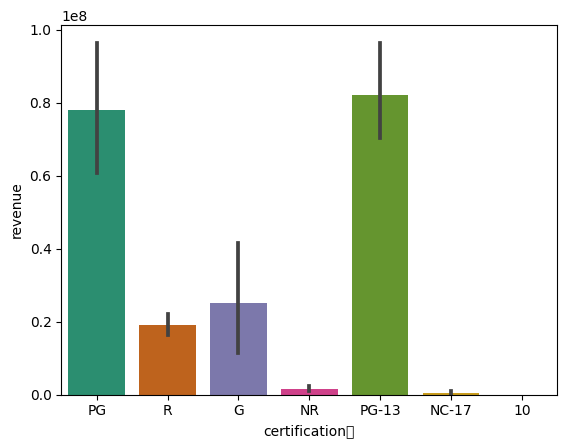

In [20]:
sns.barplot(data=df, x = 'certification\r', y='revenue', palette= 'Dark2');

In [24]:
stats.levene(*groups.values())

NameError: name 'groups' is not defined

In [25]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.kruskal(*groups.values())
result

NameError: name 'groups' is not defined